In [38]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [39]:
data = pd.read_csv(
    'http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv',
    index_col=0
)
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

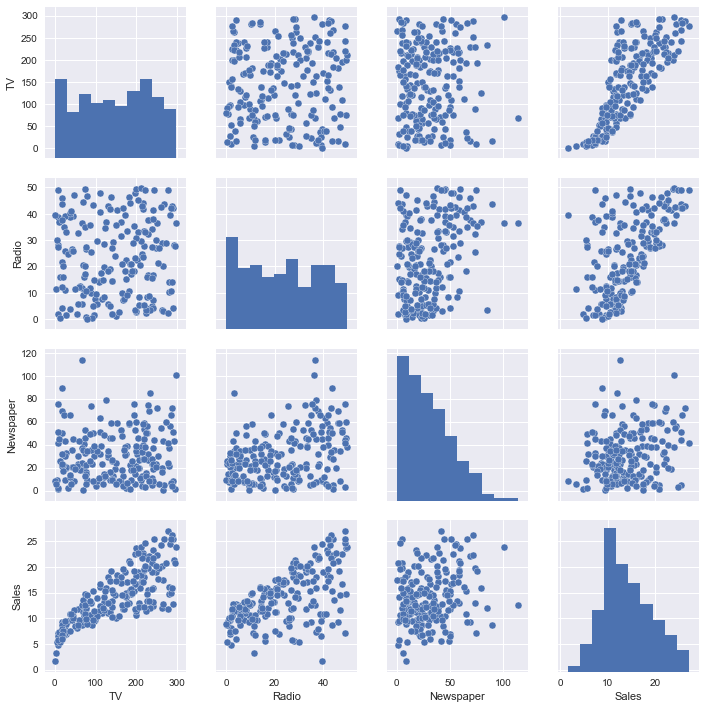

In [40]:
# Checking the relationships between sales and the other variables (bottom row of the pairplot)
sns.pairplot(data)
plt.show()

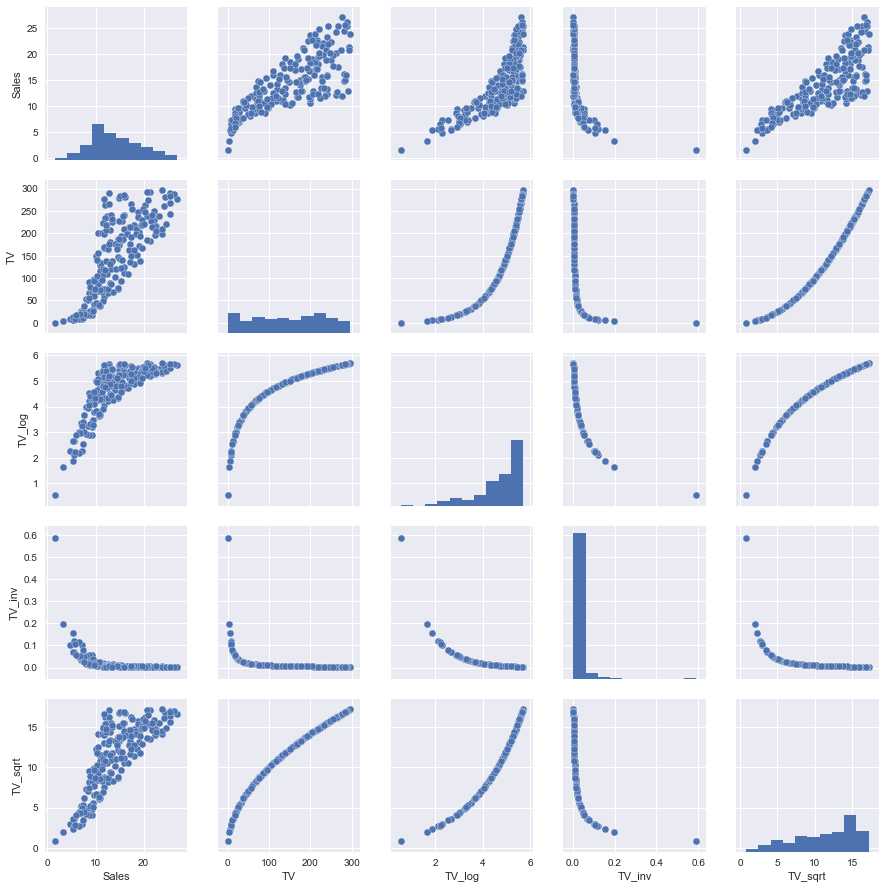

In [41]:
# Let's try a few transformations of TV to get at the non-linearity of the relationship
# We add 1 because you can't log 0.
data['TV_log']=np.log(data['TV']+1)
# We add 1 because you can't divide by 0.
data['TV_inv']=1/(data['TV']+1)
data['TV_sqrt']=np.sqrt(data['TV'])

# Look at the top row
sns.pairplot(data[['Sales','TV','TV_log','TV_inv','TV_sqrt']])
plt.show()

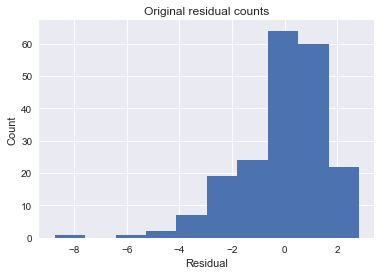

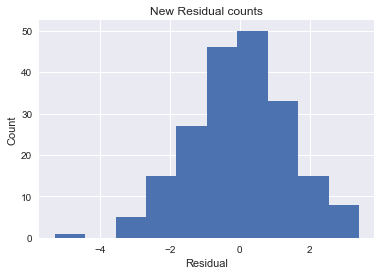


Coefficients: 
 [[  9.74947557e-01   1.94767873e-01  -5.25277959e-04]]

Intercept: 
 [-1.60927984]

R-squared:
0.928954905381


In [45]:

# Looks like the square root transformation might be helping a bit.  Let's try the model again, using the TV_sqrt variable
regr2 = linear_model.LinearRegression()
X2 = data[['TV_sqrt','Radio','Newspaper']]
regr2.fit(X2, Y)

# Extract predicted values.
predicted2 = regr2.predict(X2).ravel()

# Calculate the error, also called the residual.
residual2 = actual - predicted2

plt.hist(residual)
plt.title('Original residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.hist(residual2)
plt.title('New Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X2, Y))


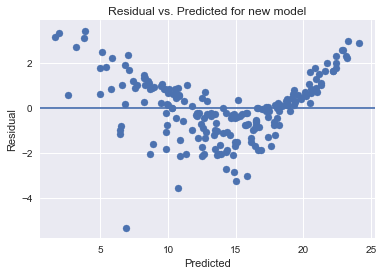

In [43]:
# Much better! R-squared is higher, too.
# Let's check if that helped the heteroskedasticity problem, too

plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted for new model')
plt.show()

# That would be a big no.  We're not doing well at predicting very high or very low sales numbers.
# Looking back at the raw data, we can see that as sales numbers get higher, the range of possible values for ads
# also gets much higher, leading to uncertainty in the model.

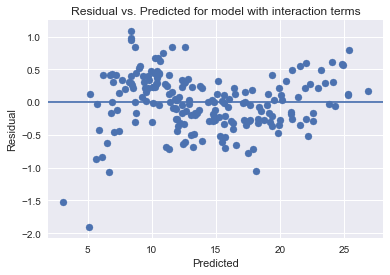


Coefficients: 
 [[  4.52614520e-01  -6.16674646e-02   2.20660516e-02   9.21150799e-03
    1.23262983e-04  -8.90022605e-04]]

Intercept: 
 [ 4.33365659]

R-squared:
0.993165964641


In [47]:
# Basically our problem is that there are a lot of possible values for sales when we get to high levels of TV, Radio,
# and Newspaper ads.  But maybe we can get more specific if we look at what happens to Sales when the combination of
# TV and Radio is high, for example, vs when only TV is high or only Radio is high.
# We can explore this by creating two-way interaction terms and putting them in the model.

data['TV_Radio']= data['TV_sqrt']*data['Radio']
data['Newspaper_Radio']= data['Newspaper']*data['Radio']
data['TV_Newspaper']= data['TV_sqrt']*data['Newspaper']

regr3 = linear_model.LinearRegression()
X3 = data[['TV_sqrt','Radio','TV_Radio','Newspaper','Newspaper_Radio','TV_Newspaper']]
regr3.fit(X3, Y)

# Extract predicted values.
predicted3 = regr3.predict(X3).ravel()

# Calculate the error, also called the residual.
residual3 = actual - predicted3

plt.scatter(predicted3, residual3)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted for model with interaction terms')
plt.show()

print('\nCoefficients: \n', regr3.coef_)
print('\nIntercept: \n', regr3.intercept_)
print('\nR-squared:')
print(regr3.score(X3, Y))

# Success!  Still a few low outliers and a mild curve, but MUCH better.  And look at that R-squared!